Necessary imports and helper functions for displaying points, boxes, and masks.

In [74]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import h5py

In [75]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [95]:
ds_img_embedding = h5py.File('/home/ron/Documents/SemiSAM/data/Graz_img_embedding.h5', 'r')['img_embedding']
ds_img_embedding.keys()

<KeysViewHDF5 ['2639_0713211442_01_WRI-R1_M005']>

In [77]:
from os import getcwd
print(getcwd())

img_name = '2639_0713211442_01_WRI-R1_M005'
image = cv2.imread(f'../data/img_only_front_all_left/{img_name}.png', cv2.IMREAD_GRAYSCALE)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image = cv2.resize(image, (224, 384), interpolation=cv2.INTER_LINEAR)

/home/ron/Documents/SemiSAM/notebooks


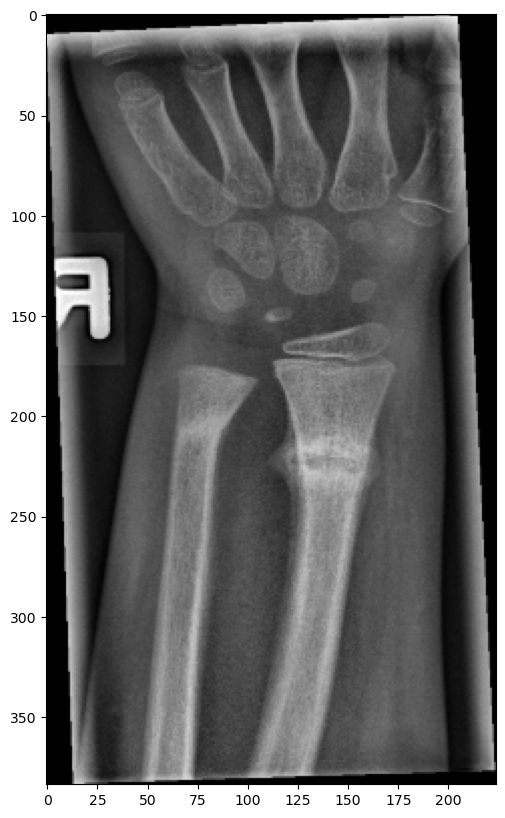

In [78]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [79]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/ron/Documents/SemiSAM/data/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"#"cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [80]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [81]:
import json

f = h5py.File('/home/ron/Documents/KidsBoneChecker/datasets/data/GRAZPEDWRI-DX/SegGraz_nnunet_predictions.h5', 'r')
lbl_idx_mapping = json.loads(f.attrs['labels'])
ds_seg_masks = f['nnUNet_prediction']
seg_masks = torch.from_numpy(ds_seg_masks[img_name][:])

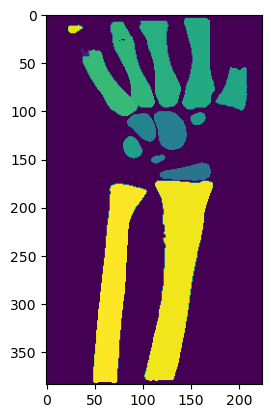

In [82]:
plt.imshow(seg_masks.float().argmax(0))

In [83]:
from segment_anything.utils.prompt_utils import PromptExtractor

prompt_extractor = PromptExtractor(seg_masks)
prompts= prompt_extractor.extract()

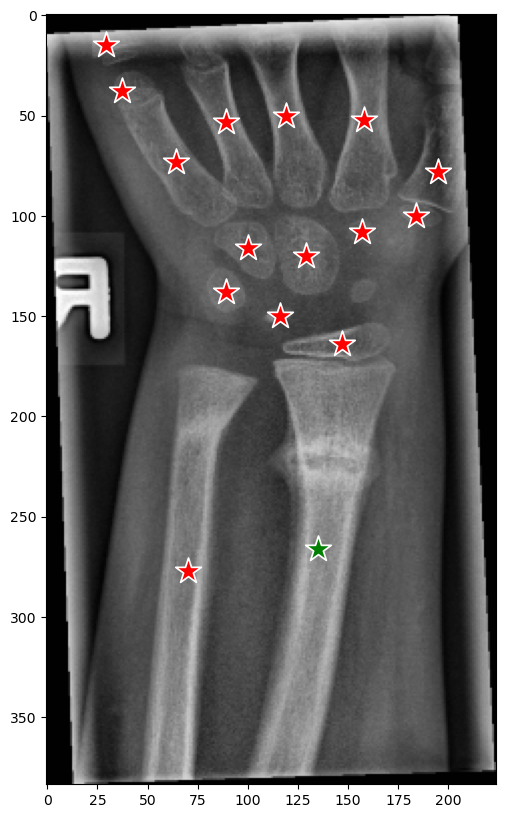

In [84]:
prompt = prompts[-2]
input_point = torch.cat([prompt.pos_seeds, prompt.neg_seeds]).numpy()
input_label = np.array([1] * prompt.pos_seeds.shape[0] + [0] * prompt.neg_seeds.shape[0])
input_box = prompt.box.numpy()

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

# SAM predictor

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [85]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [86]:
masks.shape  # (number_of_masks) x H x W

(3, 384, 224)

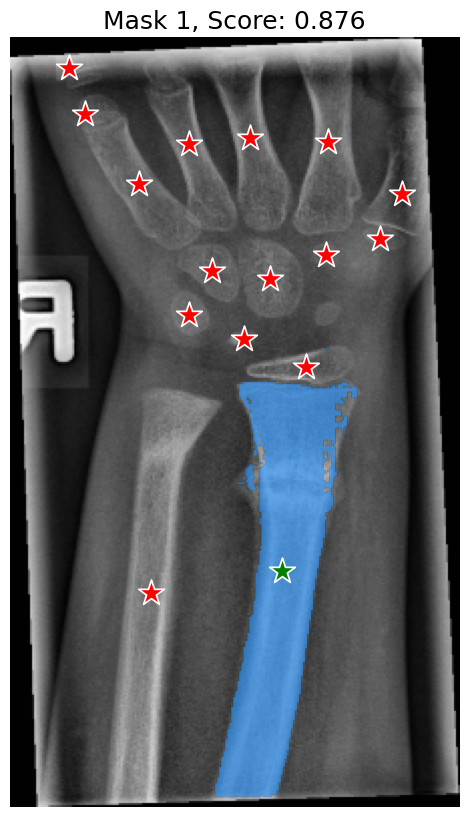

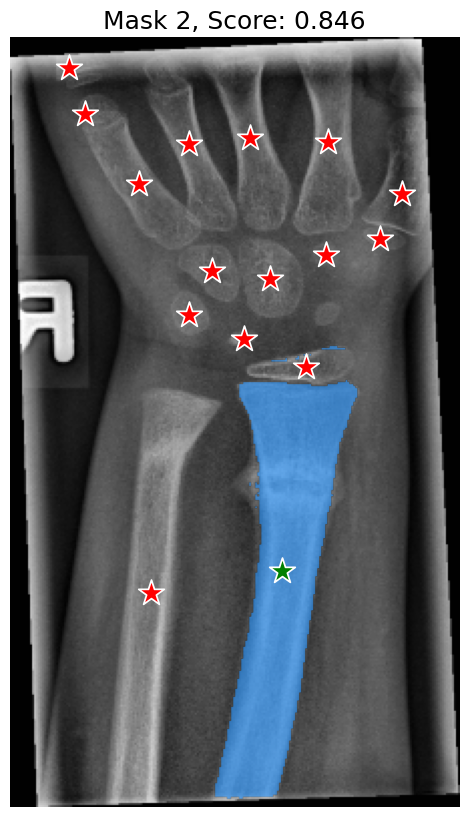

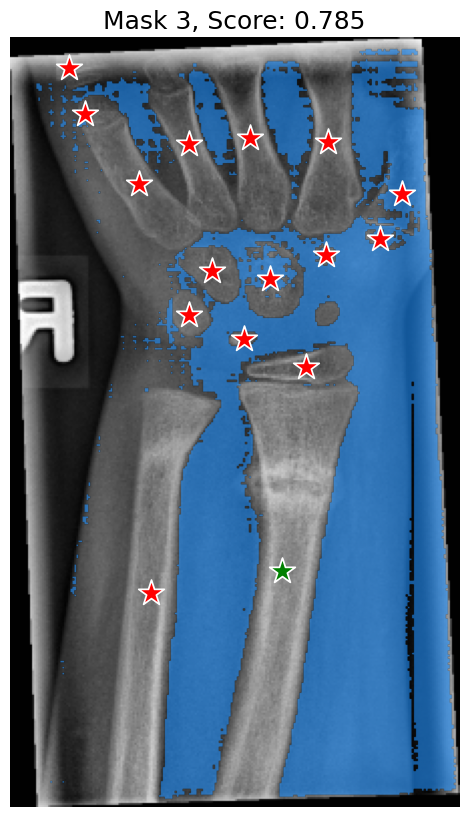

In [87]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [88]:
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

## Try mask refinement with additional point prompts

In [89]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

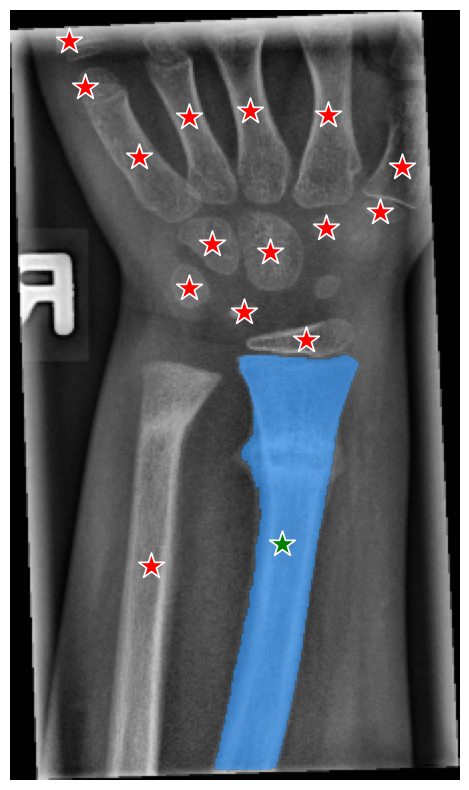

In [90]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

In [91]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)

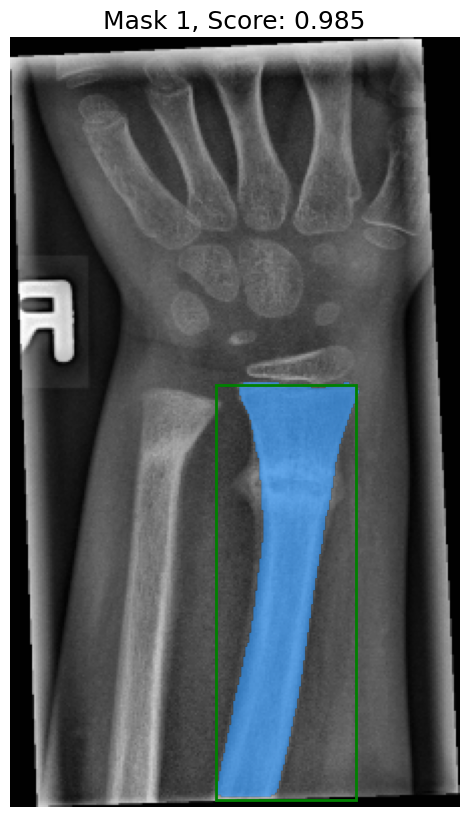

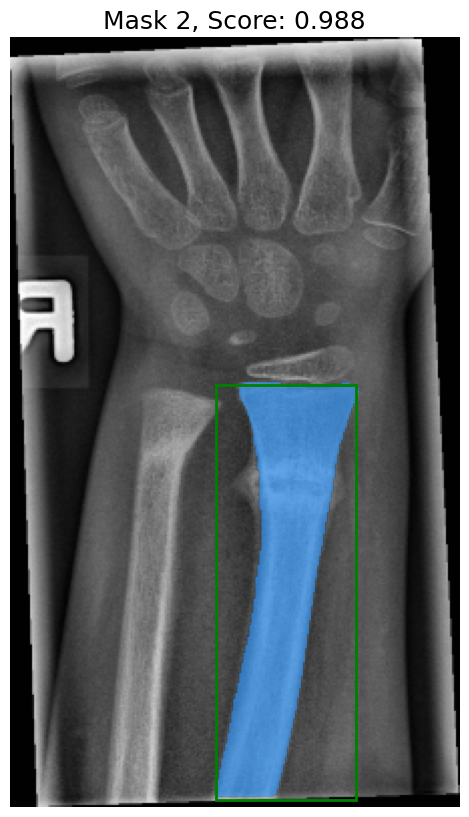

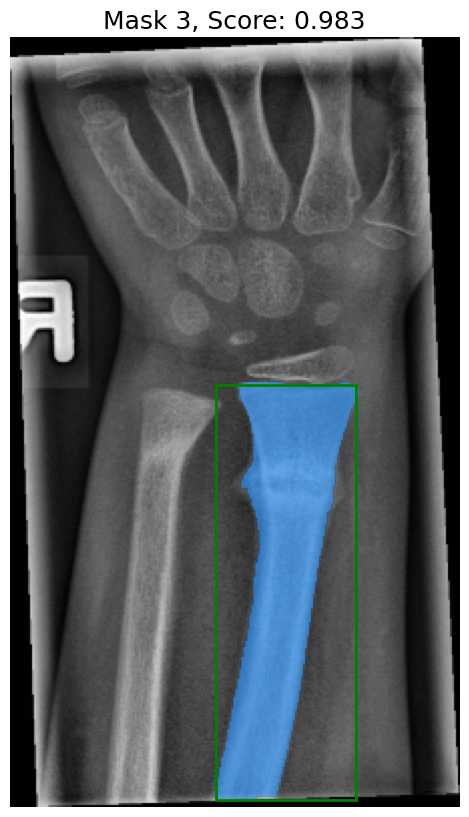

In [92]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_box(input_box, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

# SAM with loaded image embedding

In [96]:
predictor.reset_image()

predictor.features = torch.from_numpy(ds_img_embedding[img_name]['features'][:])
predictor.original_size = ds_img_embedding[img_name].attrs['original_size'].tolist()
predictor.input_size = ds_img_embedding[img_name].attrs['input_size'].tolist()
predictor.is_image_set = True

In [97]:
from segment_anything.utils.prompt_utils import scale_box

transformed_box = scale_box(torch.from_numpy(input_box).unsqueeze(0), image.shape[:2], predictor.original_size).numpy()

In [98]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=transformed_box,
    multimask_output=False,
)

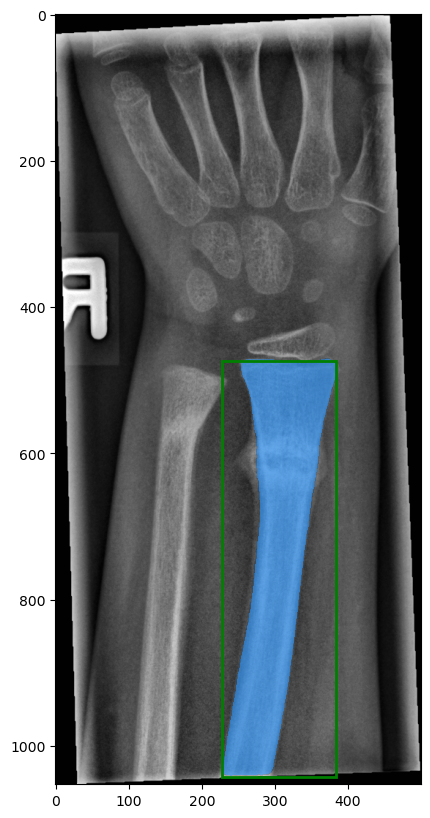

In [99]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.imread(f'../data/img_only_front_all_left/{img_name}.png', cv2.IMREAD_GRAYSCALE), 'gray')
show_mask(masks[0], plt.gca())
show_box(transformed_box[0], plt.gca())
plt.show()

# Only prompt embedding and mask decoding

In [100]:
from segment_anything.utils.prompt_utils import scale_box, scale_coords

transformed_points = scale_coords(torch.from_numpy(input_point), image.shape[:2], predictor.input_size)

with torch.inference_mode():
    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
        points=(transformed_points.unsqueeze(0), torch.from_numpy(input_label).unsqueeze(0)),
        boxes = None,
        masks = None
    )
    
    # Predict masks
    low_res_masks, iou_predictions = sam.mask_decoder(
        image_embeddings=predictor.features,
        image_pe=sam.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    
    # Upscale the masks to the original image resolution
    masks = sam.postprocess_masks(low_res_masks, predictor.input_size, predictor.original_size)
    masks = masks > sam.mask_threshold

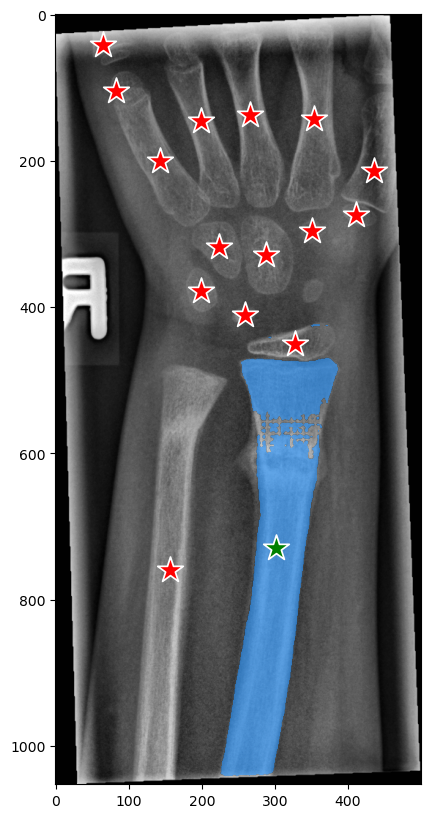

In [101]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.imread(f'../data/img_only_front_all_left/{img_name}.png', cv2.IMREAD_GRAYSCALE), 'gray')
show_mask(masks[0], plt.gca())
show_points(scale_coords(torch.from_numpy(input_point), image.shape[:2], predictor.original_size), input_label, plt.gca())
plt.show()

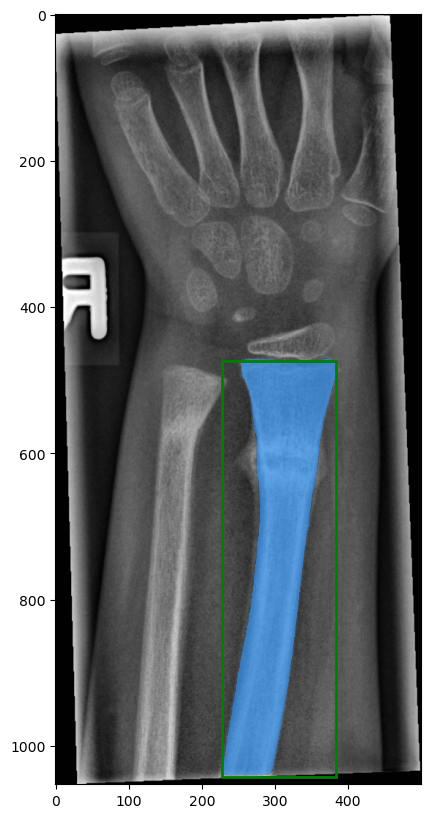

In [103]:
transformed_box = scale_box(torch.from_numpy(input_box).unsqueeze(0), image.shape[:2], predictor.input_size)

with torch.inference_mode():
    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
        points=None,
        boxes=transformed_box,
        masks=None
    )

    # Predict masks
    low_res_masks, iou_predictions = sam.mask_decoder(
        image_embeddings=predictor.features,
        image_pe=sam.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

    # Upscale the masks to the original image resolution
    masks = sam.postprocess_masks(low_res_masks, predictor.input_size, predictor.original_size)
    masks = masks > sam.mask_threshold
plt.figure(figsize=(10, 10))
plt.imshow(cv2.imread(f'../data/img_only_front_all_left/{img_name}.png', cv2.IMREAD_GRAYSCALE), 'gray')
show_mask(masks[0], plt.gca())
show_box(scale_box(torch.from_numpy(input_box).unsqueeze(0), image.shape[:2], predictor.original_size)[0], plt.gca())
plt.show()